# Capestone project: Intent identification and Out-Of-Scope (OOS) detection
# This notebook will be mainly used for the capstone project.



### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip). 

In [85]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import HuberRegressor, LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#create a logistic regression model and fit it to the churn data and classify the data based on "churn" column
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample


from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score,precision_recall_curve, roc_curve,confusion_matrix,accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay

import datetime

import warnings
warnings.filterwarnings('ignore')


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.calibration import LabelEncoder

# get top text words in the training set
from collections import Counter
# remove stopwords using countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kiran.ramanna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pair_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import scikitplot as skplt


# 1.Business Understanding
Intent detection is a critical task in Natural Language Understanding (NLU) and Natural Language Processing (NLP) applications. The goal of intent detection is to identify the intent or purpose behind a user's input or query. In other words, it involves classifying a user's input into one of several predefined categories that represent the user's intention or goal.

Intent detection is important in NLU/NLP because it enables machines to understand the meaning of user queries and respond appropriately. By correctly identifying the intent of a user's query, NLU/NLP systems can provide accurate and relevant responses, which is crucial for building conversational interfaces such as chatbots and virtual assistants.

For example, if a user inputs "What is the weather like today?", the intent of the query is to obtain information about the weather. An intent detection system can classify this query as a weather-related intent and provide a response with the current weather information. However, if the intent detection system misclassifies the query, it may provide an irrelevant or incorrect response, leading to a poor user experience.

Therefore, accurate intent detection is essential for building effective NLU/NLP systems that can understand and respond to user queries with high accuracy and relevance.

## 1.1 for this project we will be using the following dataset: https://github.com/clinc/oos-eval


# 2.Data Understand
The Click-150 dataset is a collection of 150 thousand search queries sampled from the Yandex Logs Database. This dataset can be used for various Natural Language Understanding (NLU) tasks such as intent detection, entity recognition, and sentiment analysis.

Intent detection, in particular, is an essential task in the field of NLU and NLP because it helps to identify the purpose or goal of a user's input. In the context of the Click-150 dataset, intent detection can help businesses understand what their users are searching for on their website or app. This knowledge can be used to optimize search results, provide better recommendations, and improve overall user experience.

For example, if a user searches for "hotels in New York", the intent can be identified as "hotel search" and relevant results can be provided to the user. Similarly, if a user searches for "best deals on flights to Paris", the intent can be identified as "flight search" and the user can be provided with relevant offers or deals on flights to Paris. By accurately detecting user intent, businesses can provide personalized and relevant recommendations to their users, which can lead to increased user satisfaction and loyalty.ing


In [97]:
# read oos data
# DATA_OOS_PLUS = 'oos-eval/data/data_oos_plus.json'
# DATA_FULL = 'oos-eval/data/data_full.json'
# DATA_SMALL = 'oos-eval/data/data_small.json'
# oos = json.load(open(DATA_FULL, 'r'))

# directly load data from url into json
import urllib.request, json
with urllib.request.urlopen("https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json") as url:
    oos = json.loads(url.read().decode())

len(oos)
# show keys
oos.keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

#### 2.1
- oos dataset has 6 keys. Looks like data is already segregated into train, test and validation sets. We will use the train set for training and validation set for testing our model.
- Next Lets look at the samples in each of the keys.

In [98]:


#create a dataframe from json, with column names ['text', 'intent']
def create_df_from_json(path):
    data = json.load(open(path, 'r'))
    df = pd.DataFrame(data)
    df = df[['text', 'intent']]
    return df



INTENT_COLUMN = 'intent'
TEXT_COLUMN = 'text'

df_train = pd.DataFrame.from_dict(oos['train'])
df_train.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'train set : {df_train.shape}: unique intents {df_train[INTENT_COLUMN].nunique()}')

df_test = pd.DataFrame.from_dict(oos['test'])
df_test.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'test set : {df_test.shape}: unique intents {df_test[INTENT_COLUMN].nunique()}')

df_val = pd.DataFrame.from_dict(oos['val'])
df_val.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'val set : {df_val.shape}: unique intents {df_val[INTENT_COLUMN].nunique()}')



df_train_oos = pd.DataFrame.from_dict(oos['oos_train'])
df_train_oos.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'df_train_oos set : {df_train_oos.shape}: unique intents {df_train_oos[INTENT_COLUMN].nunique()}')

df_test_oos = pd.DataFrame.from_dict(oos['oos_test'])
df_test_oos.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'df_test_oos set : {df_test_oos.shape}: unique intents {df_test_oos[INTENT_COLUMN].nunique()}')


df_val_oos = pd.DataFrame.from_dict(oos['oos_val'])
df_val_oos.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'df_val_oos set : {df_val_oos.shape}: unique intents {df_val_oos[INTENT_COLUMN].nunique()}')

# full dataset
# train set : (15000, 2): unique intents 150
# test set : (4500, 2): unique intents 150
# val set : (3000, 2): unique intents 150
# df_train_oos set : (250, 2): unique intents 1
# df_test_oos set : (1000, 2): unique intents 1
# df_val_oos set : (100, 2): unique intents 1


train set : (15000, 2): unique intents 150
test set : (4500, 2): unique intents 150
val set : (3000, 2): unique intents 150
df_train_oos set : (250, 2): unique intents 1
df_test_oos set : (1000, 2): unique intents 1
df_val_oos set : (100, 2): unique intents 1


#### 2.2
- for oos intent, we have 1250 samples and known intents we have 22500 samples when all the data is combined.

In [103]:
# create X, y
X_train = df_train[[TEXT_COLUMN]]
y_train = df_train[INTENT_COLUMN]

X_test = df_test[[TEXT_COLUMN]]
y_test = df_test[INTENT_COLUMN]

X_val = df_val[[TEXT_COLUMN]]
y_val = df_val[INTENT_COLUMN]


In [102]:
# check shape of each dataframes
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')


X_train shape: (15000, 1), y_train shape: (15000,)
X_test shape: (4500, 1), y_test shape: (4500,)
X_val shape: (3000, 1), y_val shape: (3000,)


In [109]:
# count unique intents
print(f'total unique intents other than oos in each set: train {y_train.nunique()}, test {y_test.nunique()}, val {y_val.nunique()}')

total unique intents other than oos in each set: train 150, test 150, val 150


#### 2.3
- All the data is in text format.
- We will need to use label encoder to convert the text to numbers for training the model.

# 3. Data Preparation
- Now that we have the data, we need to prepare it for training the model.
- We will use label encoder to convert the text to numbers for training the model.
- We will use the train set for training and validation set for testing our model.

In [110]:

# def get_top_text_words(X_train, n=10):
#     vectorizer = TfidfVectorizer(stop_words='english')
#     vectorizer.fit_transform(X_train)
#     words = vectorizer.get_feature_names_out()
#     total_counts = X_train.sum(axis=0).tolist()[0]
#     counter = Counter(dict(zip(words, total_counts)))
#     most_common = counter.most_common(n)
#     return most_common

# # plot top text words
# import matplotlib.pyplot as plt
# import seaborn as sns
# def plot_top_text_words(X_train, n=10):
#     most_common = get_top_text_words(X_train, n)
#     print("most_common", most_common)
#     words = [w[0] for w in most_common]
#     counts = [w[1] for w in most_common]
#     sns.barplot(x=counts, y=words)
#     plt.title(f'{n} most common words')
#     plt.show()

# # plot_top_text_words(X_train, 10)


In [35]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

# 4. Modeling

Lets start with a dummy model to get a baseline accuracy. We will use the test set to test the model.

In [36]:
# dummy classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train[TEXT_COLUMN], y_train)
y_pred = dummy_clf.predict(X_test[TEXT_COLUMN])
# print(classification_report(y_test, y_pred, target_names=le.classes_))
print(classification_report(y_test, y_pred, target_names=list(map(str, le.classes_))))



                           precision    recall  f1-score   support

      accept_reservations       0.01      1.00      0.01        30
          account_blocked       0.00      0.00      0.00        30
                    alarm       0.00      0.00      0.00        30
       application_status       0.00      0.00      0.00        30
                      apr       0.00      0.00      0.00        30
            are_you_a_bot       0.00      0.00      0.00        30
                  balance       0.00      0.00      0.00        30
             bill_balance       0.00      0.00      0.00        30
                 bill_due       0.00      0.00      0.00        30
              book_flight       0.00      0.00      0.00        30
               book_hotel       0.00      0.00      0.00        30
               calculator       0.00      0.00      0.00        30
                 calendar       0.00      0.00      0.00        30
          calendar_update       0.00      0.00      0.00     

#### 4.1
- Accuracy of the dummy model is 0.01
- This is the baseline accuracy for our model. Any model we build should have accuracy greater than this.

#### 4.2
- We will use SGDClassifier to train our model as a basic valid model.

In [116]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

model = make_pipeline(TfidfVectorizer(stop_words='english'), 
              SGDClassifier())
model.fit(X_train[TEXT_COLUMN], y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('sgdclassifier', SGDClassifier())])

In [117]:

y_pred = model.predict(X_test[TEXT_COLUMN])

y_test = le.transform(y_test)
y_pred = le.transform(y_pred)
y_val = le.transform(y_val)


print(classification_report(y_test, y_pred, target_names=list(map(str, le.classes_))))



              precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.66      0.83      0.74        30
           2       0.94      0.97      0.95        30
           3       0.86      1.00      0.92        30
           4       0.97      0.93      0.95        30
           5       0.86      1.00      0.92        30
           6       0.79      0.77      0.78        30
           7       0.58      0.70      0.64        30
           8       0.33      0.03      0.06        30
           9       0.96      0.77      0.85        30
          10       0.94      1.00      0.97        30
          11       0.23      0.90      0.36        30
          12       0.75      0.60      0.67        30
          13       0.71      0.83      0.77        30
          14       0.94      0.97      0.95        30
          15       0.76      0.97      0.85        30
          16       0.86      1.00      0.92        30
          17       0.88    

#### 4.3
- Accuracy of the SGDClassifier model is 0.81
- This is a good accuracy for our model. We will try to improve this accuracy by using different models.

4.4 
- Lets see top 10 words in train and test set.

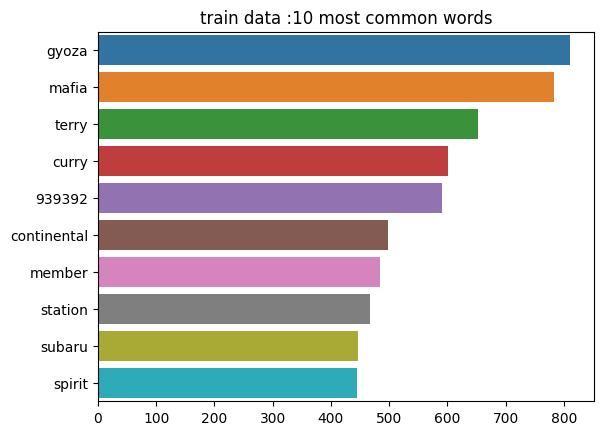

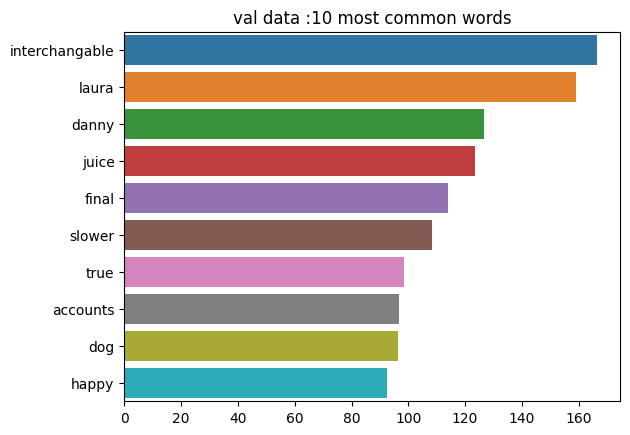

In [39]:

def plot_top_text_words(X_train, n, title):
    vectorizer = TfidfVectorizer()
    X_train_vect = vectorizer.fit_transform(X_train)
    word_counts = X_train_vect.sum(axis=0).tolist()[0]
    words = [word for word, count in sorted(zip(vectorizer.vocabulary_.keys(), word_counts), key=lambda pair: pair[1], reverse=True)[:n]]
    counts = [count for word, count in sorted(zip(vectorizer.vocabulary_.keys(), word_counts), key=lambda pair: pair[1], reverse=True)[:n]]
    sns.barplot(x=counts, y=words)
    plt.title(f'{title} data :{n} most common words')
    plt.show()

    
plot_top_text_words(X_train[TEXT_COLUMN], 10, 'train')


# plot top text words
plot_top_text_words(X_val[TEXT_COLUMN], 10, 'val')


In [40]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
# plot_confusion_matrix(y_test, y_pred)

4.5
- Lets create few reusable functions to train and test the model.

In [132]:
# 4.5.1 create a dataframe for capturing model performance and results
dict = {'model': [],
        'train_acc': [],
        'test_acc': [],
        'val_acc': [],
        'time': [],
        'split': [],
        'grid': [],
        'data': [],
        'precision' : [],
        'recall' : [],
        'f1-score' : [],
        'support' : [],
        'timestamp' : []}
out_df = pd.DataFrame(dict)
# columns to show in model performance dataframe
model_building_cols = ['model', 'data', 'train_acc', 'test_acc', 'time', 'split', 'precision', 'recall', 'f1-score', 'support']
evaluation_cols = ['model', 'data', 'val_acc', 'time', 'precision', 'recall', 'f1-score', 'support']


In [119]:
# 4.5.2 create a reusable function to save each model's performance and results

def calcOutRow(model, name, X_train, X_test, y_train, y_test, X_val, y_val, split, dataCSVName, timeTaken, gridSearch):
    y_pred = model.predict(X_test)
    # if dataCSVName contains 'oos', then use X_val, y_val
    if 'oos' in dataCSVName:
        # print('shape of y_pred:', y_pred.shape, 'shape of y_test:', y_test.shape, 'shape of X_test:', X_test.shape)
        # print classification report
        print(classification_report(y_test, y_pred, target_names=list(map(str, le.classes_))))
        plotAll3(y_test, model.predict_proba(X_test))

    start = time.time()
    report = classification_report(y_test, y_pred, output_dict=True)
    end = time.time()
    report_df = pd.DataFrame(report).transpose()
    print(f"Time taken to run classification_report: {end - start}")
    report_df.columns = ['precision', 'recall', 'f1-score', 'support']
    rowIndexName = 'True'
    if 'True' in report_df.index:
        report_df.loc['True']
        rowIndexName = 'True'
    else:
        # report_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)
        report_df.loc['mean'] = report_df.mean()
        rowIndexName = 'mean'
    eachRow = {'model':name,
        'train_acc': model.score(X_train, y_train),
        'test_acc': model.score(X_test, y_test),
        'val_acc': model.score(X_val, y_val),
        'time': np.round(timeTaken, 4),
        'split': split,
        'grid': gridSearch,
        'data': dataCSVName,
        'precision' : report_df.loc[rowIndexName]['precision'],
        'recall' : report_df.loc[rowIndexName]['recall'],
        'f1-score' : report_df.loc[rowIndexName]['f1-score'],
        'support' : report_df.loc[rowIndexName]['support'],
        'timestamp' : datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    out_df.loc[len(out_df)] = eachRow
    

In [120]:
# 4.5.3 create a reusable function to fit and predict model

def calcAcc_score(data_df, X_columns, y_columns, model_pipe, name, grid_param, split, dataCSVName):
    print(f'######## calcAcc_score {name} - {dataCSVName} start ########')
    # X = data_df[X_columns]
    # y = data_df[y_columns]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    start = time.time()
    model = model_pipe.fit(X_train, y_train)
    end = time.time()
    print(f'basic fit {name} timetaken: {end-start}')
    print(f'{name}', f'      split :{split} Train ACC: {model.score(X_train, y_train)}')
    print(f'{name}', f'      split :{split} Test ACC: {model.score(X_test, y_test)}')
    print(f'{name}', f'      split :{split} Val ACC: {model.score(X_val, y_val)}')
    calcOutRow(model, name, X_train, X_test, y_train, y_test, X_val, y_val, split, dataCSVName, end-start, 'No')
    # if (name == 'DecisionTreeClassifier' or name == 'LogisticRegression' or name == 'KNeighborsClassifier' or name == 'SVC'):
    # if (grid_param is not None):
    #     # calculate permutation importance
    #     # print('start permutation importance'+time.ctime())
    #     start = time.time()
    #     perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    #     end = time.time()
    #     # select top 10 features into list
    #     top10important = X_test.columns[np.argsort(perm_importance.importances_mean)[-10:]].tolist()
    #     # plot permutation importance for top 10 features
    #     sorted_idx = perm_importance.importances_mean.argsort()
    #     plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    #     plt.title("Permutation Importances:"+name +" timetaken:"+str(end-start))
    #     plt.show()
    # else:

        
    if grid_param is None:
        return
    # consider only top 10 permutation importance features for grid search
    # ohe_cols_grid = []
    # ss_cols_grid = []
    # for col in top10important:
    #     if X[col].dtype == 'object':
    #         ohe_cols_grid.append(col)
    #     else:
    #         ss_cols_grid.append(col)
    # preprocessor = make_column_transformer((ohe, ohe_cols_grid), (ss, ss_cols_grid))

    # grid_pipe = Pipeline(steps=[
    #     ('preprocessor', preprocessor),
    #     model_pipe.steps[1:][0]])

    # X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X, y, test_size=split, random_state=42)
    X_train_grid = X_train
    X_test_grid = X_test
    y_train_grid = y_train
    y_test_grid = y_test
    X_val_grid = X_val
    y_val_grid = y_val
    
    start = time.time()
    grid = GridSearchCV(model_pipe, grid_param)
    grid.fit(X_train_grid, y_train_grid)
    end = time.time()
    print(f'{name}-grid', f' split :{split} Train ACC: {grid.best_estimator_.score(X_train_grid, y_train_grid)}, grid-fit timetaken: {end-start}')
    print(f'{name}-grid', f' split :{split} Test ACC: {grid.best_estimator_.score(X_test_grid, y_test_grid)}')
    calcOutRow(grid.best_estimator_, name, X_train_grid, X_test_grid, y_train_grid, y_test_grid, X_val_grid, y_val_grid, split, dataCSVName, end-start, 'Yes')
    print(f'{name}-grid', f' split :{split} best params', grid.best_params_)
    y_pred_grid = grid.best_estimator_.predict(X_test_grid)
    print(classification_report(y_test_grid, y_pred_grid))
    print(f'######## calcAcc_score {name} end ########')
    # plotConfusionMatrics(name, model, grid.best_estimator_, X_test, y_test, X_test_grid, y_test_grid)

    

In [121]:
# 4.5.4 create a reusable function to test differnt classifiers namely:
# DecisionTreeClassifier,
# LogisticRegression,
# KNeighborsClassifier,
# SVC,
# RandomForestClassifier,
# XGBClassifier
# This also does grid search for each classifier


def validateClassifiers( preprocessor, data_df, X_columns, y_columns, dataCSVName):
    # for i in [0.1, 0.2, 0.3, 0.4]:
    random_state = 42
    for i in [0.2]:
        #1. DecisionTreeClassifier
        dt_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(random_state=random_state))])

        dt_params = {'classifier__min_impurity_decrease': np.logspace(-3, 3, 7),
                'classifier__max_depth': np.arange(2, 11, 2),
                'classifier__min_samples_split': np.logspace(-2, 2, 5)}
        calcAcc_score(data_df, X_columns, y_columns, dt_pipe, 'DecisionTreeClassifier', None, i, dataCSVName)

        # #2. LogisticRegression
        lr_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=random_state))])

        lr_params = {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': np.logspace(-1, 1, 3),
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__max_iter': [100]
        }
        calcAcc_score(data_df, X_columns, y_columns, lr_pipe, 'LogisticRegression', None, i, dataCSVName)

        # #3. KNeighborsClassifier
        knn_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', KNeighborsClassifier())])

        knn_params = {
            'classifier__n_neighbors': np.linspace(100, 3000, 10, dtype=int),
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
        }
        calcAcc_score(data_df, X_columns, y_columns, knn_pipe, 'KNeighborsClassifier', None, i, dataCSVName)

        #4. SVC
        # choose proper class_weight 
        svc_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', SVC(random_state=random_state, probability=True))])


        svc_params = {
            'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
        calcAcc_score(data_df, X_columns, y_columns, svc_pipe, 'SVC', None, i, dataCSVName)

        # #5. RandomForestClassifier
        rf_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=random_state))])
        
        rf_params = {
            'classifier__n_estimators': [100, 200, 300, 400, 500],
            'classifier__max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
            'classifier__min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40, 45],
            'classifier__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'classifier__bootstrap': [True, False]
        }
        calcAcc_score(data_df, X_columns, y_columns, rf_pipe, 'RandomForestClassifier', None, i, dataCSVName)
        
        # #6. XGBClassifier
        xgb_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(random_state=random_state))])
        
        xgb_params = {
            'classifier__n_estimators': [100, 200, 300, 400, 500],
            'classifier__max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
            'classifier__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
            'classifier__min_child_weight': [1, 2, 3, 4],
            'classifier__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
            'classifier__colsample_bytree': [0.3, 0.4, 0.5, 0.7]
        }
        calcAcc_score(data_df, X_columns, y_columns, xgb_pipe, 'XGBClassifier', None, i, dataCSVName)
        


In [122]:
# 4.5.5 label encoder for y_train, y_test, y_val
# - Also create a column transformer to check 2 different vectorizers
# (1)) TfidfVectorizer
# (2)) CountVectorizer

# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# count vectorizer
count = CountVectorizer(stop_words='english')

# label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
le.fit(y_test)
y_test = le.transform(y_test)
le.fit(y_val)
y_val = le.transform(y_val)


preprocessor_tfidf = make_column_transformer(
    (tfidf, TEXT_COLUMN),
    remainder='passthrough')

preprocessor_count = make_column_transformer(
    (count, TEXT_COLUMN),
    remainder='passthrough')



In [48]:
# 4.5.6 run classifiers for validation for tfidf vectorizer
validateClassifiers(preprocessor_tfidf, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-tfidf')


######## calcAcc_score DecisionTreeClassifier start ########
basic fit DecisionTreeClassifier timetaken: 2.015634775161743
DecisionTreeClassifier       split :0.2 Train ACC: 0.979
DecisionTreeClassifier       split :0.2 Test ACC: 0.7424444444444445
DecisionTreeClassifier       split :0.2 Val ACC: 0.7483333333333333
Time taken to run classification_report: 0.019840002059936523
######## calcAcc_score LogisticRegression start ########
basic fit LogisticRegression timetaken: 8.865994930267334
LogisticRegression       split :0.2 Train ACC: 0.9199333333333334
LogisticRegression       split :0.2 Test ACC: 0.8135555555555556
LogisticRegression       split :0.2 Val ACC: 0.811
Time taken to run classification_report: 0.013822078704833984
######## calcAcc_score KNeighborsClassifier start ########
basic fit KNeighborsClassifier timetaken: 0.11926102638244629
KNeighborsClassifier       split :0.2 Train ACC: 0.7442
KNeighborsClassifier       split :0.2 Test ACC: 0.6306666666666667
KNeighborsClassifi

In [49]:
# 4.5.7 run classifiers for validation for count vectorizer
validateClassifiers(preprocessor_count, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-count')

######## calcAcc_score DecisionTreeClassifier start ########
basic fit DecisionTreeClassifier timetaken: 0.85794997215271
DecisionTreeClassifier       split :0.2 Train ACC: 0.979
DecisionTreeClassifier       split :0.2 Test ACC: 0.7531111111111111
DecisionTreeClassifier       split :0.2 Val ACC: 0.7586666666666667
Time taken to run classification_report: 0.012955904006958008
######## calcAcc_score LogisticRegression start ########
basic fit LogisticRegression timetaken: 11.379181146621704
LogisticRegression       split :0.2 Train ACC: 0.942
LogisticRegression       split :0.2 Test ACC: 0.8142222222222222
LogisticRegression       split :0.2 Val ACC: 0.8163333333333334
Time taken to run classification_report: 0.014430046081542969
######## calcAcc_score KNeighborsClassifier start ########
basic fit KNeighborsClassifier timetaken: 0.1208031177520752
KNeighborsClassifier       split :0.2 Train ACC: 0.7815333333333333
KNeighborsClassifier       split :0.2 Test ACC: 0.5924444444444444
KNeighb

In [133]:
# 4.5.8 show dataframe with gradient background
# different cmap options: https://matplotlib.org/stable/tutorials/colors/colormaps.html

cm = sns.light_palette("seagreen", as_cmap=True)
out_df[model_building_cols].style.background_gradient(cmap=cm)



,model,data,train_acc,test_acc,time,split,precision,recall,f1-score,support


# 4.6 : model testing conclutions:
- Best model which could identify the intent is SVC with TFIDF Vecotorizer with accuracy of 0.83 accuracy on test set.
- mean precetion is 0.85 which is best compared to other classifiers.
- SVC is also the slowest model to train and test.
- LogisticRegression with Count Vectorizer is the second best model with accuracy of 0.82 on test set. Train accuracy = 0.94 and mean precision of 0.84 and very comparable to SVC with having upper hand on better time to fit and predict.
- KNeighborsClassifier is the fastest model to train and test but the train accuracy is 0.74, lowest among all.

# 5. Evaluation

Out of scope intent classification refers to the task of identifying when a user's input does not fall into any of the predefined intent categories. In other words, it involves detecting when a user's query is about a topic or task that the chatbot or NLU system is not trained to handle.

Out of scope detection is an important aspect of intent classification, as it allows the system to respond appropriately when it encounters inputs that it cannot handle. If the system does not have the ability to detect when an input is out of scope, it may provide irrelevant or inaccurate responses, which can result in a poor user experience.

To handle out of scope inputs, the system can either provide a generic response indicating that it does not understand the input, or it can try to redirect the user to an appropriate resource or provide a list of options for the user to choose from. In any case, being able to detect out of scope inputs is a critical component of an effective NLU system.

- Lets create dataframe which includes oos data in it.
- Create a new column `oos` which will be a boolean column with 1 for oos data and 0 for known data.

In [51]:
# X_train = df_train_oos[[TEXT_COLUMN]]
# y_train = df_train_oos[INTENT_COLUMN]

# X_test = df_test_oos[[TEXT_COLUMN]]
# y_test = df_test_oos[INTENT_COLUMN]

# X_val = df_val_oos[[TEXT_COLUMN]]
# y_val = df_val_oos[INTENT_COLUMN]

# validateClassifiers(preprocessor_tfidf, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-tfidf-oos')
# validateClassifiers(preprocessor_count, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-count-oos')

In [52]:
OOS_COLUMN = 'oos'
# merge df_train and df_train_oos
df_train_all = pd.concat([df_train, df_train_oos])
# create a new column to indicate if the intent is oos or not
df_train_all[OOS_COLUMN] = df_train_all[INTENT_COLUMN].apply(lambda x: 1 if x == OOS_COLUMN else 0)
print('train', df_train_all[OOS_COLUMN].value_counts())

# merge df_test and df_test_oos
df_test_all = pd.concat([df_test, df_test_oos])
# create a new column to indicate if the intent is oos or not
df_test_all[OOS_COLUMN] = df_test_all[INTENT_COLUMN].apply(lambda x: 1 if x == OOS_COLUMN else 0)
print('test', df_test_all[OOS_COLUMN].value_counts())

# merge df_val and df_val_oos
df_val_all = pd.concat([df_val, df_val_oos])
# create a new column to indicate if the intent is oos or not
df_val_all[OOS_COLUMN] = df_val_all[INTENT_COLUMN].apply(lambda x: 1 if x == OOS_COLUMN else 0)
print('val', df_val_all[OOS_COLUMN].value_counts())


train oos
0    15000
1      100
Name: count, dtype: int64
test oos
0    4500
1    1000
Name: count, dtype: int64
val oos
0    3000
1     100
Name: count, dtype: int64


In [123]:
# 5.1 create train, test, val sets
# # import train_valid_test_split
# from fast_ml.model_development import train_valid_test_split

X_train = df_train_all[[TEXT_COLUMN]]
y_train = df_train_all[OOS_COLUMN]

X_test = df_test_all[[TEXT_COLUMN]]
y_test = df_test_all[OOS_COLUMN]

X_val = df_val_all[[TEXT_COLUMN]]
y_val = df_val_all[OOS_COLUMN]


In [124]:
# 5.2 run a DummyClassifier for baseline

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train[TEXT_COLUMN], y_train)
y_pred = dummy_clf.predict(X_test[TEXT_COLUMN])
# print(classification_report(y_test, y_pred, target_names=le.classes_))
print(classification_report(y_test, y_pred))
# confusion matrix




              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1000

    accuracy                           0.82      5500
   macro avg       0.41      0.50      0.45      5500
weighted avg       0.67      0.82      0.74      5500



# 5.2
- Dummy Classifier accuracy is 0.82. Anything above this is a good model.

In [125]:
# 5.3 Few reusable functions to validate binary classifiers

# plot roc curve
def plot_confusion_matrix(y_test, y_pred, ax):
    threshold = 0.5
    y_pred_binary = np.where(y_pred[:, 1] >= threshold, 1, 0)
    fig = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_binary), display_labels=['in-scope', 'oos']).plot(ax=ax)
    # fig.ax_.set_title('Confision Matrix : predict_proba (threshold = 0.5)')
    # split title in 2 lines
    title = 'Confision Matrix : predict_proba (threshold = 0.5)'.split(':')
    fig.ax_.set_title(title[0] + ':\n' + title[1], loc='left')
    # move title up
    fig.ax_.title.set_position([.5, 1.05])
    # set sub title
    # fig.im_.colorbar.remove()
    

def plot_roc_curve(y_test, y_pred, ax):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'auc = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    # show grid
    ax.grid(True)
    ax.legend(loc='lower right')
    ax.set_title('ROC Curve')
    
    
# plot cumilative gains curve and lift curve
def plot_cumulative_gains_curve(y_test, y_pred, ax):
    skplt.metrics.plot_cumulative_gain(y_test, y_pred, ax=ax)
    
def plot_lift_curve(y_test, y_pred, ax):
    skplt.metrics.plot_lift_curve(y_test, y_pred, ax=ax)

    
def plotAll3(y_test, y_pred):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle('ROC Curve, Cumulative Gains Curve, Lift Curve')
    plot_confusion_matrix(y_test, y_pred, ax=ax[0])
    plot_roc_curve(y_test, y_pred, ax=ax[1])
    plot_cumulative_gains_curve(y_test, y_pred, ax=ax[2])
    plot_lift_curve(y_test, y_pred, ax=ax[3])
    plt.show()
    


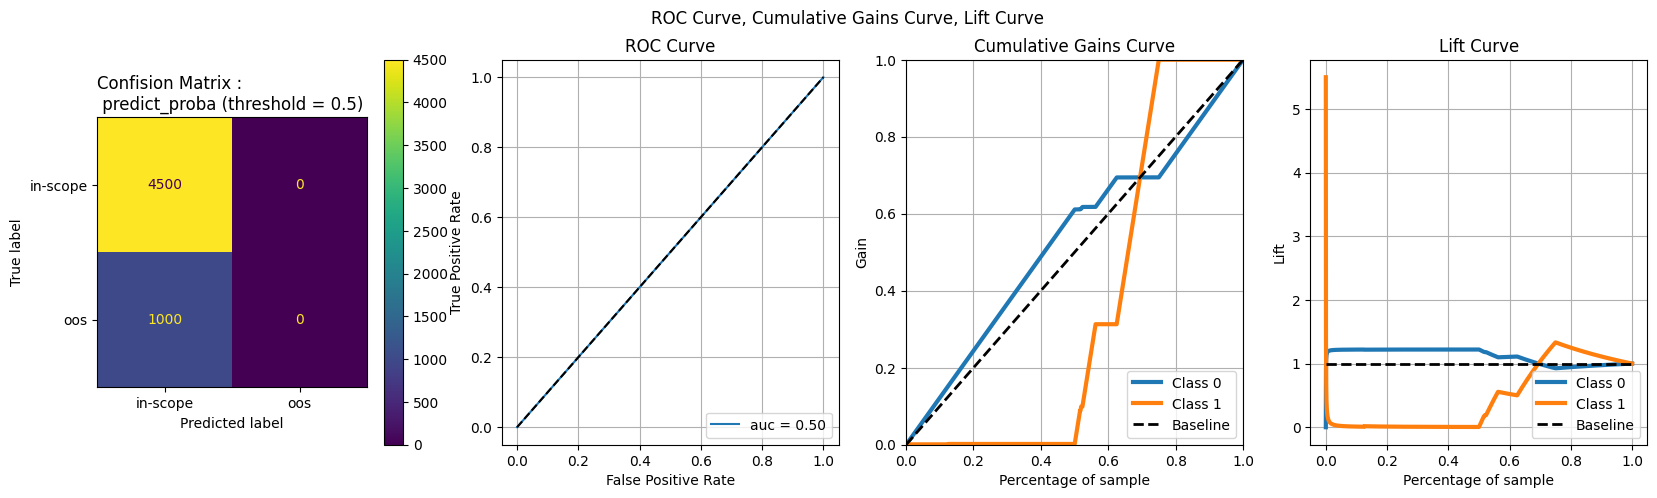

In [126]:
# check the Confusion Matrix, ROC Curve, Cumulative Gains Curve, Lift Curve for DummyClassifier
y_pred = dummy_clf.predict_proba(X_test[TEXT_COLUMN])
plotAll3(y_test, y_pred)

In [128]:
# 5.4 create a baseline model using LogisticRegression
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

model = make_pipeline(TfidfVectorizer(stop_words='english'), 
              LogisticRegression())
model.fit(X_train[TEXT_COLUMN], y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1000

    accuracy                           0.82      5500
   macro avg       0.41      0.50      0.45      5500
weighted avg       0.67      0.82      0.74      5500



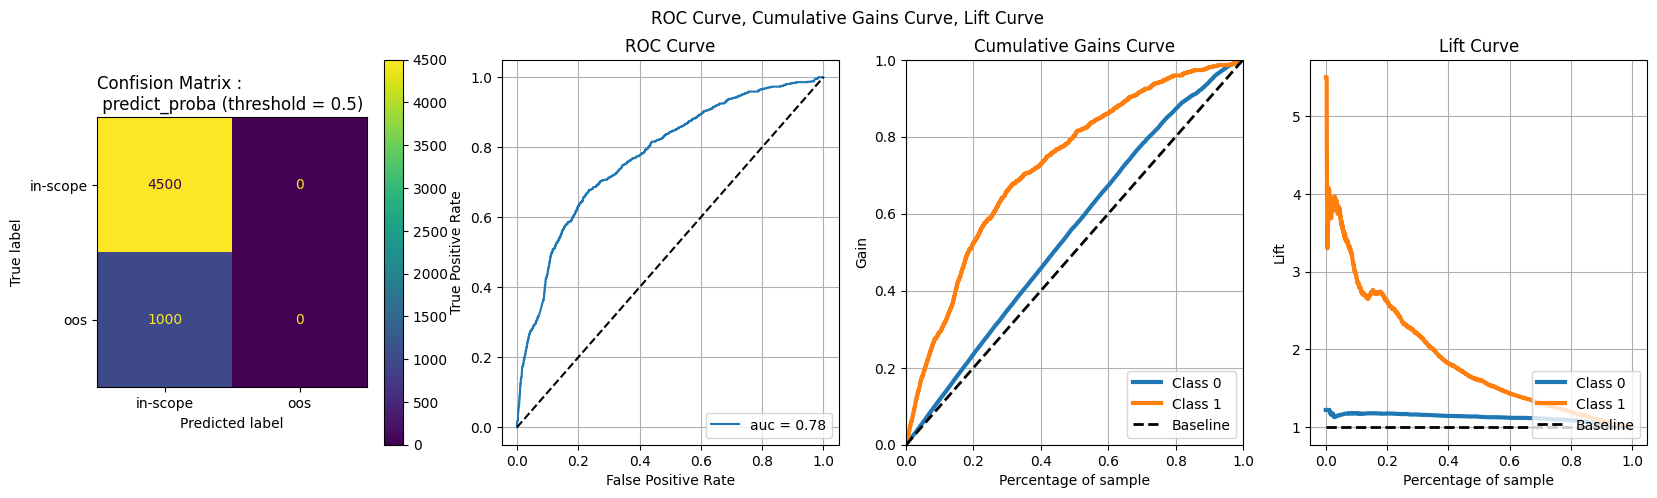

In [130]:

y_pred = model.predict(X_test[TEXT_COLUMN])

y_test = le.transform(y_test)
y_pred = le.transform(y_pred)
y_val = le.transform(y_val)


# print(classification_report(y_test, y_pred, target_names=list(map(str, le.classes_))))
print(classification_report(y_test, y_pred))
plotAll3(y_test, model.predict_proba(X_test[TEXT_COLUMN]))




# 5.3
- A basic LogisticRegression shows accuracy of 0.82 which is on par with dummy classifier.
- Lets try to improve this accuracy by using different models.

######## calcAcc_score DecisionTreeClassifier - clinc150-tfidf-oos start ########
basic fit DecisionTreeClassifier timetaken: 0.5524768829345703
DecisionTreeClassifier       split :0.2 Train ACC: 1.0
DecisionTreeClassifier       split :0.2 Test ACC: 0.8236363636363636
DecisionTreeClassifier       split :0.2 Val ACC: 0.967741935483871
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.73      0.05      0.09      1000

    accuracy                           0.82      5500
   macro avg       0.78      0.52      0.50      5500
weighted avg       0.81      0.82      0.75      5500



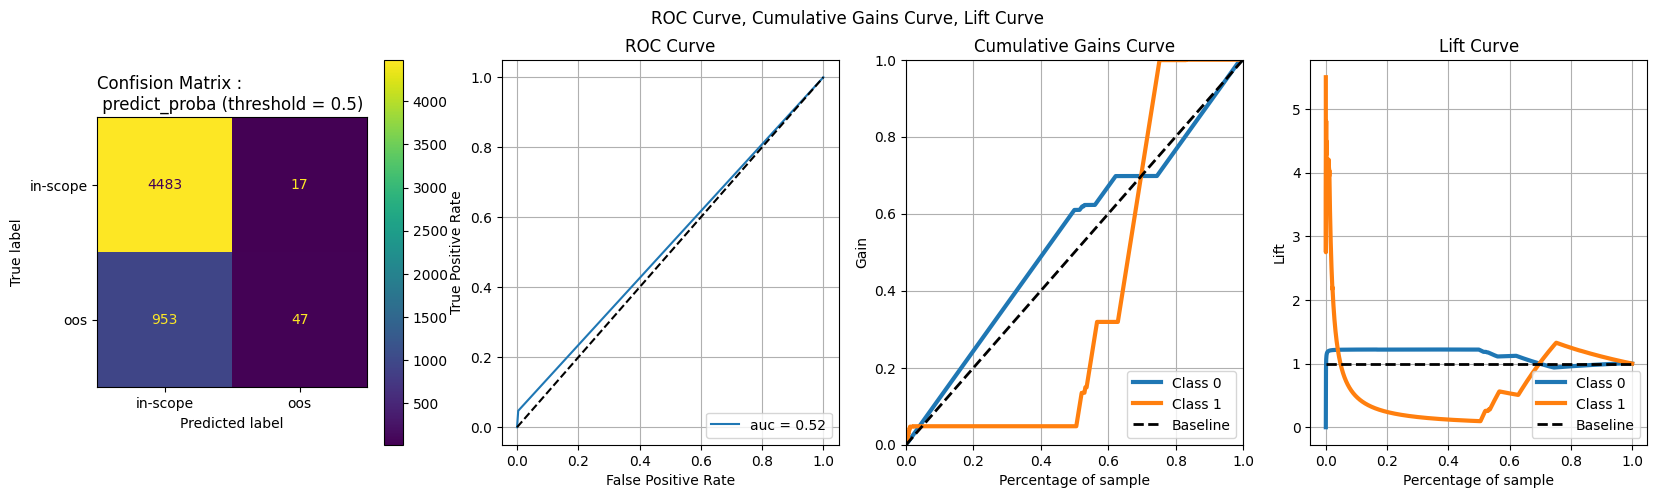

Time taken to run classification_report: 0.01032710075378418
######## calcAcc_score LogisticRegression - clinc150-tfidf-oos start ########
basic fit LogisticRegression timetaken: 0.14844799041748047
LogisticRegression       split :0.2 Train ACC: 0.9933774834437086
LogisticRegression       split :0.2 Test ACC: 0.8181818181818182
LogisticRegression       split :0.2 Val ACC: 0.967741935483871
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1000

    accuracy                           0.82      5500
   macro avg       0.41      0.50      0.45      5500
weighted avg       0.67      0.82      0.74      5500



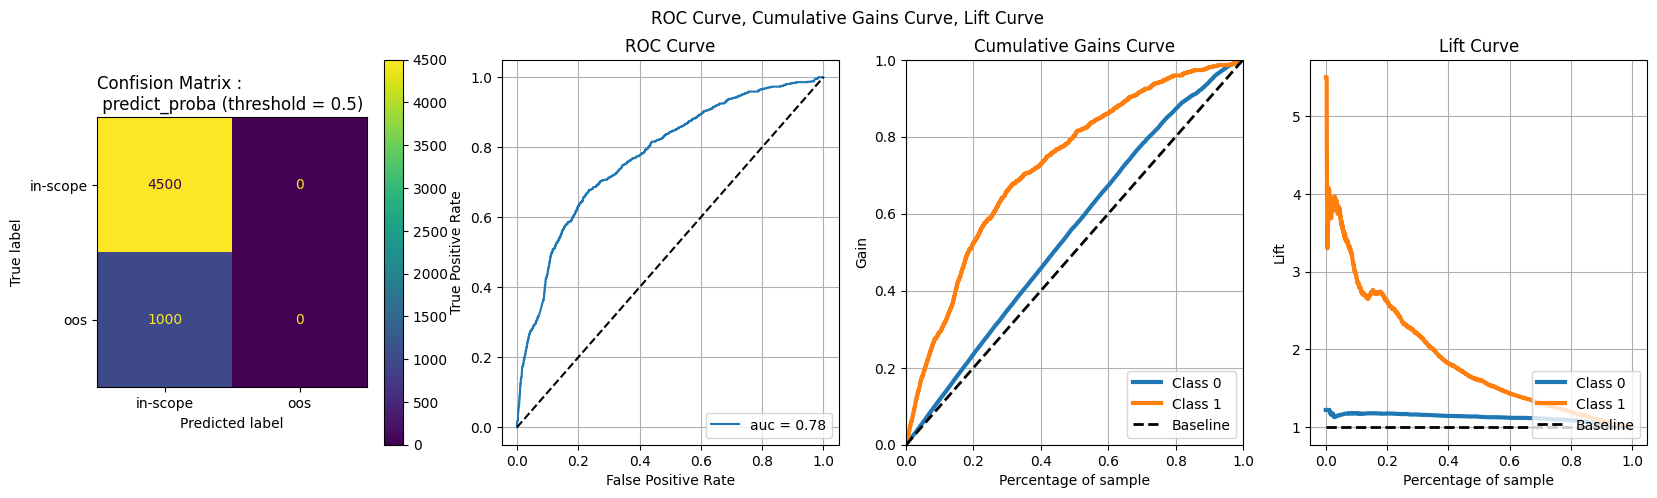

Time taken to run classification_report: 0.012282133102416992
######## calcAcc_score KNeighborsClassifier - clinc150-tfidf-oos start ########
basic fit KNeighborsClassifier timetaken: 0.13825488090515137


KeyboardInterrupt: 

In [136]:
# 5.5 Create different models and validate them
validateClassifiers(preprocessor_tfidf, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-tfidf-oos')
validateClassifiers(preprocessor_count, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-count-oos')

In [137]:
# show dataframe with gradient background
# different cmap options: https://matplotlib.org/stable/tutorials/colors/colormaps.html

cm = sns.light_palette("xkcd:golden", as_cmap=True)
out_df[out_df["data"].str.contains("oos")][model_building_cols].style.background_gradient(cmap=cm)
# data = Dataset.load_from_df(df[['userId', 'title', 'rating']], reader)



,model,data,train_acc,test_acc,time,split,precision,recall,f1-score,support
0,DecisionTreeClassifier,clinc150-tfidf-oos,1.000000,0.823636,0.552500,0.200000,0.794099,0.642421,0.612818,3300.164727
1,LogisticRegression,clinc150-tfidf-oos,0.993377,0.818182,0.148400,0.200000,0.542975,0.627273,0.580909,3300.163636


# 5.4
- DecisionTreeClassifier irrespective of the vectorizer used is a good model with test accuracy of 0.82. This also has slightly better numbers in terms of precision and recall for oos identification.
- KNieghborsClassifier is the fastest but with accuracy of 0.81 which is comparable with dummy as well as other models.


# 6. Deployment


In [138]:
# show dataframe with gradient background
# different cmap options: https://seaborn.pydata.org/generated/seaborn.light_palette.html

cm = sns.light_palette("seagreen", as_cmap=True)
# does not contain oos
out_df[~out_df["data"].str.contains("oos")][evaluation_cols].style.background_gradient(cmap=cm)



,model,data,val_acc,time,precision,recall,f1-score,support


In [139]:
# show dataframe with gradient background
# different cmap options: https://seaborn.pydata.org/generated/seaborn.light_palette.html

cm = sns.light_palette("xkcd:golden", as_cmap=True)
# does not contain oos
out_df[out_df["data"].str.contains("oos")][model_building_cols].style.background_gradient(cmap=cm)



,model,data,train_acc,test_acc,time,split,precision,recall,f1-score,support
0,DecisionTreeClassifier,clinc150-tfidf-oos,1.000000,0.823636,0.552500,0.200000,0.794099,0.642421,0.612818,3300.164727
1,LogisticRegression,clinc150-tfidf-oos,0.993377,0.818182,0.148400,0.200000,0.542975,0.627273,0.580909,3300.163636


# 7. Conclusion
- We have used 3 different models to identify the intent of the text.
    - SVC with TFIDF Vectorizer
    - LogisticRegression with Count Vectorizer
    - KNeighborsClassifier with Count Vectorizer
- We have used 2 different models to identify if the text is out of scope.
    - DecisionTreeClassifier
    - KNeighborsClassifier

- Further improvements can be done by using different models and tuning the hyperparameters.
- We can also use different vectorizers and see if that improves the accuracy.
- We can also improve the quality of the data by removing the stop words and incorporating lemmatization and stemming.